# RAD-seq assembly with ipyrad

In [75]:
import ipyrad as ip
import ipyrad.analysis as ipa
import pandas as pd
import toytree
import toyplot, toyplot.svg

#### CSV file with accession IDs, species names, and sample info
Here we want to use the `specie` label which is the new updated name (`oldname` is original description).

In [2]:
df = pd.read_csv("../metadata/pablo-cacti-relabeled-re.csv")
df.head(10)

,accession,Genus,specie,subspecie,Localidad,Lat,Long,oldname
0,1075,Eriosyce,litoralis,NaN,TotoralilloIVR,-30.068,-71.375,litoralis
1,1083,Eriosyce,litoralis,NaN,TotoralilloIVR,-30.069,-71.376,litoralis
2,1093,Eriosyce,clavata,NaN,Qda.Manqueza,-29.914,-70.943,clavata
3,1288,Eriosyce,subgibbosa,NaN,PeninsuladeHualpenVIIIR,-36.757,-73.176,subgibbosa
4,1290,Eriosyce,subgibbosa,NaN,PeninsuladeHualpenVIIIR,-36.757,-73.176,subgibbosa
5,1332,Eriosyce,castanea,NaN,CerroLaLajuela(StaCruz),-34.664,-71.417,castanea
6,1333,Eriosyce,castanea,NaN,CerroLaLajuela(StaCruz),-34.664,-71.417,castanea
7,1349,Eriosyce,litoralis,NaN,Pichidanguii,-32.156,-71.528,subgibbosa
8,1350,Eriosyce,litoralis,NaN,Pichidanguii,-32.156,-71.528,subgibbosa
9,1351,Eriosyce,litoralis,NaN,Pichidanguii,-32.156,-71.528,subgibbosa


### Extract sequence alignment
Here we will use an IMAP filter to select only accession IDs NOT IN DROP. 

In [45]:
DROP = [
    '1530',
    '1530x',
    'BV85',
    '1093',
    'HPG1',
    'HPG2',
    'HPG4',
    'SXM1',
    'SXM2',
    'SXM3',
    '1332',
    '1333',
    'BV185',
    'BV152',
    '1288',
    '1290',
    'reference',
    '1351',
    '1352',
    '1353',
    '1541',
    '1594',
]
len(DROP)

22

In [59]:
IMAP = {'keep': [i for i in df.accession.tolist() if i not in DROP]}

In [79]:
# filter and select an alignment with max 50% missing data
wex = ipa.window_extracter(
    name='test',#Eriosyce-ref-2021-sub',
    workdir='../analysis-window_extracter/',
    data="/pinky/deren/pablo-cacti/assembly/Eriosyce-ref-2021_outfiles/Eriosyce-ref-2021.seqs.hdf5",
    scaffold_idxs=range(200000),  # ALL LOCI
    mincov=0.6,
    rmincov=0.0,
    imap=IMAP,
)

# show alignment size
display(wex.stats)

,scaffold,start,end,sites,snps,missing,samples
0,concatenated,0,1279651,1279651,63881,0.207,76


In [60]:
# filter and select an alignment with max 50% missing data
wex = ipa.window_extracter(
    name='Eriosyce-ref-2021-sub',
    workdir='../analysis-window_extracter/',
    data="/pinky/deren/pablo-cacti/assembly/Eriosyce-ref-2021_outfiles/Eriosyce-ref-2021.seqs.hdf5",
    scaffold_idxs=range(200000),  # ALL LOCI
    mincov=0.6,
    rmincov=0.2,
    imap=IMAP,
)

# show alignment size
display(wex.stats)

# run extracter to write phylip file output
wex.run(force=True)

,scaffold,start,end,sites,snps,missing,samples
0,concatenated,0,1279651,1279651,63817,0.208,76


Wrote data to /pinky/deren/pablo-cacti/analysis-window_extracter/Eriosyce-ref-2021-sub.phy


In [61]:
# run raxml on the new alignment phy file
rax = ipa.raxml(
    name="Erioscye-ref-2021-sub",
    workdir="../analysis-raxml",
    data="../analysis-window_extracter/Eriosyce-ref-2021-sub.phy",
    T=15,
    N=100,
    m="GTRCAT"
)

# print the raxml command
print(rax.command)

# run raxml inference
rax.run(force=True)

/home/deren/miniconda3/envs/ipy/bin/raxmlHPC-PTHREADS-AVX2 -f a -T 15 -m GTRCAT -n Erioscye-ref-2021-sub -w /pinky/deren/pablo-cacti/analysis-raxml -s /pinky/deren/pablo-cacti/analysis-window_extracter/Eriosyce-ref-2021-sub.phy -p 54321 -N 100 -x 12345
job Erioscye-ref-2021-sub finished successfully


### Draw the tree result

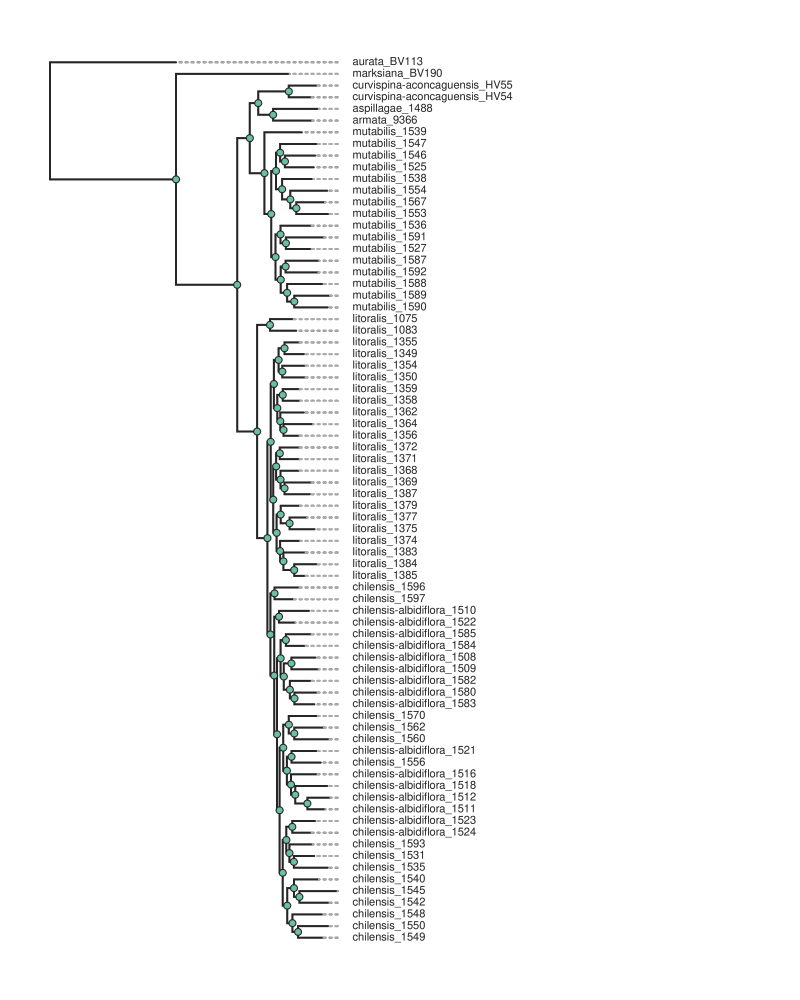

In [86]:
# plot the tree result
tre = toytree.tree("../analysis-raxml/RAxML_bipartitions.Erioscye-ref-2021-sub")

# get mapping of accessions to sample names
#namedict = dict(zip(df.accession, df.specie + "_" + df.accession + "_" + df.Localidad))
namedict = dict(zip(df.accession, df.specie + "_" + df.accession))

# root on suspected outgroup (reference)
tre = tre.root("BV113")

# get node colors
node_colors = []
for sup in tre.get_node_values("support", 1, 1):
    sup = int(sup)
    if sup > 90:
        node_colors.append("black")
    elif sup > 50:
        node_colors.append("grey")
    else:
        node_colors.append("white")

# draw tree with sample names
canvas, axes, mark = tre.draw(
    #tip_labels_colors=tcolors,
    tip_labels_align=True,
    #node_labels="support",
    #node_labels_style={"-toyplot-anchor-shift": "-15px", "baseline-shift": "5px"},
    node_sizes=[7 if i else 0 for i in tre.get_node_values("support")],
    node_colors=node_colors,
    node_style={"stroke": "#262626"},
    width=800,
    shrink=50,
    tip_labels=[namedict.get(i) if namedict.get(i) else i for i in tre.get_tip_labels()],
);

toyplot.svg.render(canvas, "../figures/raxml-sub.svg")  
#toyplot.svg.render(canvas, "../figures/raxml-sub-localidad.svg")

canvas

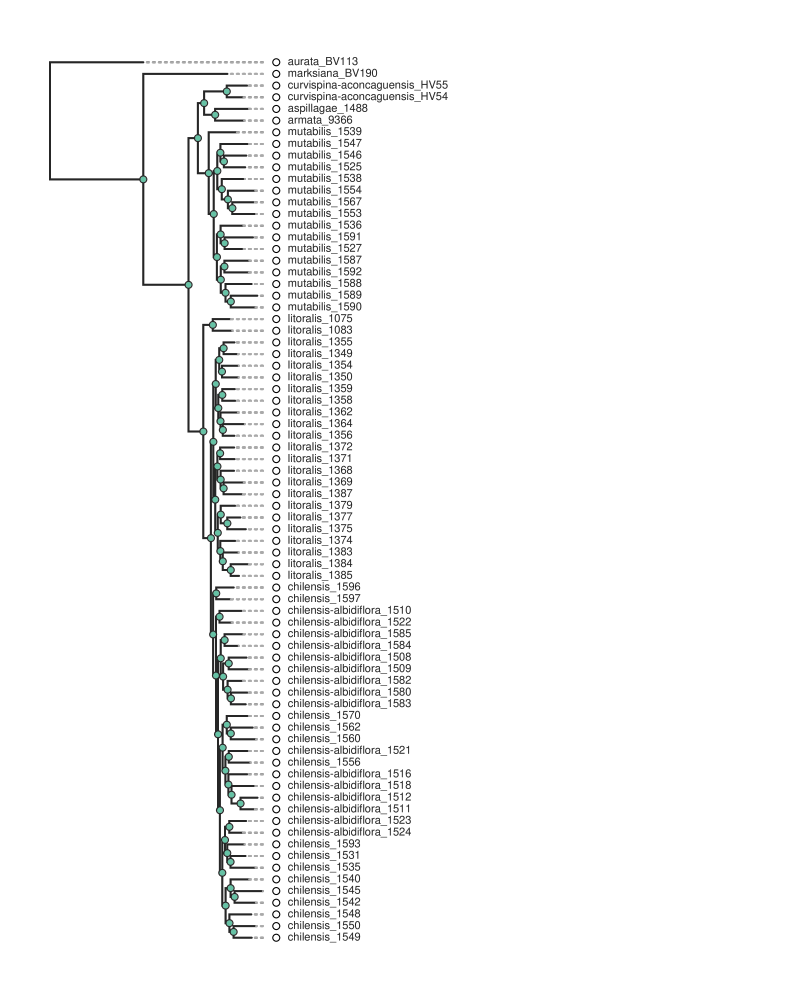

In [108]:
# plot the tree result
tre = toytree.tree("../analysis-raxml/RAxML_bipartitions.Erioscye-ref-2021-sub")

# get mapping of accessions to sample names
#namedict = dict(zip(df.accession, df.specie + "_" + df.accession + "_" + df.Localidad))
namedict = dict(zip(df.accession, df.specie + "_" + df.accession))

# root on suspected outgroup (reference)
tre = tre.root("BV113")

# get node colors
node_colors = []
for sup in tre.get_node_values("support", 1, 1):
    sup = int(sup)
    if sup > 90:
        node_colors.append("black")
    elif sup > 50:
        node_colors.append("grey")
    else:
        node_colors.append("white")

# draw tree with sample names
canvas, axes, mark = tre.draw(
    #tip_labels_colors=tcolors,
    tip_labels_align=True,
    #node_labels="support",
    #node_labels_style={"-toyplot-anchor-shift": "-15px", "baseline-shift": "5px"},
    node_sizes=[7 if i else 0 for i in tre.get_node_values("support")],
    node_colors=node_colors,
    node_style={"stroke": "#262626"},
    width=800,
    shrink=50,
    tip_labels=[namedict.get(i) if namedict.get(i) else i for i in tre.get_tip_labels()],
    tip_labels_style={"-toyplot-anchor-shift": "25px"}
);

import numpy as np
axes.scatterplot(
    np.repeat(0.0015, tre.ntips),
    np.arange(tre.ntips),
    size=7,
    mstyle={"fill": "none", 'stroke': 'black'},
)


toyplot.svg.render(canvas, "../figures/raxml-sub-tips.svg")  
#toyplot.svg.render(canvas, "../figures/raxml-sub-localidad.svg")

canvas

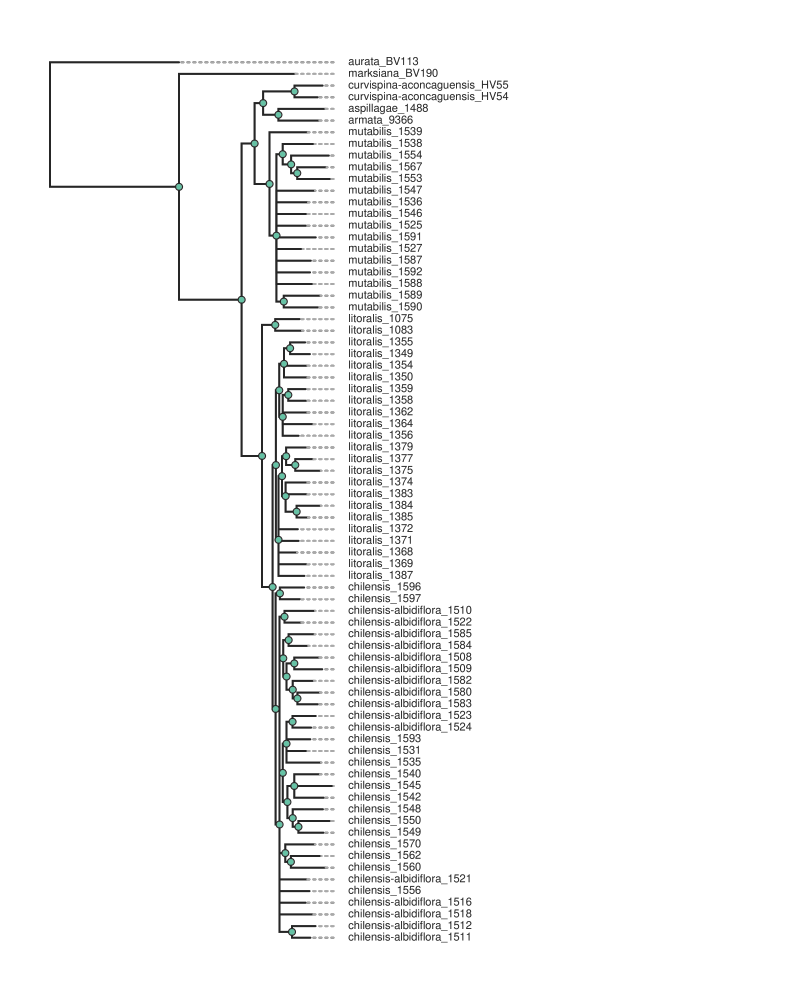

In [92]:
# plot the tree result
tre = toytree.tree("../analysis-raxml/RAxML_bipartitions.Erioscye-ref-2021-sub")

# get mapping of accessions to sample names
#namedict = dict(zip(df.accession, df.specie + "_" + df.accession + "_" + df.Localidad))
namedict = dict(zip(df.accession, df.specie + "_" + df.accession))

# root on suspected outgroup (reference)
tre = tre.root("BV113").collapse_nodes(min_support=51)

# get node colors
node_colors = []
for sup in tre.get_node_values("support", 1, 1):
    sup = int(sup)
    if sup > 90:
        node_colors.append("black")
    elif sup > 50:
        node_colors.append("grey")
    else:
        node_colors.append("white")

# draw tree with sample names
canvas, axes, mark = tre.draw(
    #tip_labels_colors=tcolors,
    tip_labels_align=True,
    #node_labels="support",
    #node_labels_style={"-toyplot-anchor-shift": "-15px", "baseline-shift": "5px"},
    node_sizes=[7 if i else 0 for i in tre.get_node_values("support")],
    node_colors=node_colors,
    node_style={"stroke": "#262626"},
    width=800,
    shrink=50,
    tip_labels=[namedict.get(i) if namedict.get(i) else i for i in tre.get_tip_labels()],
);

#toyplot.svg.render(canvas, "../figures/raxml-sub.svg")  
#toyplot.svg.render(canvas, "../figures/raxml-sub-localidad.svg")

canvas

## Plot phylogeny WITH D-statistics

In [141]:
# plot the tree result
tre = toytree.tree("../analysis-raxml/RAxML_bipartitions.Erioscye-ref-2021-sub")

# get mapping of accessions to sample names
namedict = dict(zip(df.accession, df.specie + "_" + df.accession))

# root on suspected outgroup (reference)
tre = tre.root("BV113")

# get node colors
node_colors = []
for sup in tre.get_node_values("support", 1, 1):
    sup = int(sup)
    if sup > 90:
        node_colors.append("black")
    elif sup > 50:
        node_colors.append("grey")
    else:
        node_colors.append("white")

# draw tree with sample names
canvas, axes, mark = tre.draw(
    tip_labels_align=True,
    node_sizes=[7 if i else 0 for i in tre.get_node_values("support")],
    node_colors=node_colors,
    node_style={"stroke": "#262626"},
    width=800,
    shrink=0,
    tip_labels=[namedict.get(i) if namedict.get(i) else i for i in tre.get_tip_labels()],
    tip_labels_style={"-toyplot-anchor-shift": "25px"},
    scalebar=True,
);


import numpy as np
axes.scatterplot(
    np.repeat(0.00075, tre.ntips),
    np.arange(tre.ntips),
    size=7,
    mstyle={"fill": "none", 'stroke': 'black'},
)

axes.scatterplot(
    np.repeat(0.0125, tre.ntips),
    np.arange(tre.ntips),
    size=2,
    mstyle={"fill": "grey", 'stroke': 'none'},
)


dstats1 = pd.read_csv("./analysis-dstats-1.csv", index_col=0)
dstats1 = dstats1.drop(index=[1530])
#print(dstats1)

axes.scatterplot(
    dstats1.D / 10,
    [tre.get_tip_labels().index(str(i)) for i in dstats1.index],
    size=4,
    mstyle={"fill": "green", 'stroke': 'none'},
)


#toyplot.svg.render(canvas, "../figures/tree-dstats.svg")  


canvas

ValueError: '1541' is not in list

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="tf13dd830822c419d85b722d73dc02793" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 800.0 1000.0" width="800.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> chilensis_1549 chilensis_1550 chilensis_1548 chilensis_1542 chilensis_1545 chilensis_1540 chilensis_1535 chilensis_1531 chilensis_1593 chilensis-albidiflora_1524 chilensis-albidiflora_1523 chilensis-albidiflora_1511 chilensis-albidiflora_1512 chilensis-albidiflora_1518 chilensis-albidiflora_1516 chilensis_1556 chilensis-albidiflora_1521 chilensis_1560 chilensis_1562 chilensis_1570 chilensis-albidiflora_1583 chilensis-albidiflora_1580 chilensis-albidiflora_1582 chilensis-albidiflora_1509 chilensis-albidiflora_1508 chilensis-albidiflora_1584 chilensis-albidiflora_1585 chilensis-albidiflora_1522 chilensis-albidiflora_1510 chilensis_1597 chilensis_1596 litoralis_1385 litoralis_1384 litoralis_1383 litoralis_1374 litoralis_1375 litoralis_1377 litoralis_1379 litoralis_1387 litoralis_1369 litoralis_1368 litoralis_1371 litoralis_1372 litoralis_1356 litoralis_1364 litoralis_1362 litoralis_1358 litoralis_1359 litoralis_1350 litoralis_1354 litoralis_1349 litoralis_1355 litoralis_1083 litoralis_1075 mutabilis_1590 mutabilis_1589 mutabilis_1588 mutabilis_1592 mutabilis_1587 mutabilis_1527 mutabilis_1591 mutabilis_1536 mutabilis_1553 mutabilis_1567 mutabilis_1554 mutabilis_1538 mutabilis_1525 mutabilis_1546 mutabilis_1547 mutabilis_1539 armata_9366 aspillagae_1488 curvispina-aconcaguensis_HV54 curvispina-aconcaguensis_HV55 marksiana_BV190 aurata_BV113 0.000 0.003 0.007 0.010 0.014 0.017 0.020 0.024

In [134]:
tre.get_tip_labels()

['1549',
 '1550',
 '1548',
 '1542',
 '1545',
 '1540',
 '1535',
 '1531',
 '1593',
 '1524',
 '1523',
 '1511',
 '1512',
 '1518',
 '1516',
 '1556',
 '1521',
 '1560',
 '1562',
 '1570',
 '1583',
 '1580',
 '1582',
 '1509',
 '1508',
 '1584',
 '1585',
 '1522',
 '1510',
 '1597',
 '1596',
 '1385',
 '1384',
 '1383',
 '1374',
 '1375',
 '1377',
 '1379',
 '1387',
 '1369',
 '1368',
 '1371',
 '1372',
 '1356',
 '1364',
 '1362',
 '1358',
 '1359',
 '1350',
 '1354',
 '1349',
 '1355',
 '1083',
 '1075',
 '1590',
 '1589',
 '1588',
 '1592',
 '1587',
 '1527',
 '1591',
 '1536',
 '1553',
 '1567',
 '1554',
 '1538',
 '1525',
 '1546',
 '1547',
 '1539',
 '9366',
 '1488',
 'HV54',
 'HV55',
 'BV190',
 'BV113']